# Exploring venues in Hyderabad,India

## Table of Contents

- Introduction
- Data Collection from APIs
- Data Cleaning
- Methodology
- Analysis
- Results and Discussion
- Conclusion

## Introduction

### Background

Whenever a person searches for a venue in a new city, they’re highly interested in the best places that the city has to offer. The person might want to know how good a given restaurant is or the price range it falls under. This extra information would help decide which venue to choose amongst the many venues in the city. Combining the location of the venues in the city with their price and rating information would surely help visitors in a city make better informed decisions about the places they should visit.

**Hyderabad** is composed of a number of sectors spread across a total area of 650 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored. This project explores various venues in Hyderabad and attributes the data based on user ratings and average price. To explore this information, this project involves the juxtaposition of both the **Foursquare API and the Zomato API** to fetch complete information of various venues (including name, address, category, rating, and price). Further, a map of the venues with specific color attributes will be plotted to highlight their position, and information about these venues. Such plots imbibe bountiful information in the form of their colored representations and location on the map. This enables any visitor to take a quick glance and decide what place to visit.

### Interested audience

The target audience for such a project is twofold. Firstly, any person who is visiting Chandigarh, India can use the plots and maps from this project to quickly select places that suit their budget and rating preferences. Secondly, a company can use this information to create a website or a mobile application, which is updated on a regular basis, to allow individuals to the city or even expand same functionality to other places.

The aim of the project is to identify venues in Hyderabad, India based on their rating and average prices. In this notebook, we will identify various venues in the city of **Hyderabad, India**, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll **identify places that are fit for various individuals** based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## Data Collection from APIs

To begin with, we will take a look at Hyderabad on the Map using the folium library.

We will also fetch the data from two different APIs.

- **Foursquare API**: We will use the Foursquare API to fetch venues in Hyderabad starting from the middle upto 44 Kilometers in each direction.
- **Zomato API**: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

From Foursquare API (https://developers.zomato.com/api), I retrieved the following for each venue:
- **Name**: The name of the venue.
- **Category**: The category type as defined by the API.
- **Latitude**: The latitude value of the venue.
- **Longitude**: The longitude value of the venue.


From Zomato API (https://developers.zomato.com/api), I retrieved the following for each venue:
- **Name**: The name of the venue.
- **Address**: The complete address of the venue.
- **Rating**: The ratings as provided by many users.
- **Price range**: The price range the venue belongs to as defined by Zomato.
- **Price for two**: The average cost for two people dining at the place. I later convert the same to average price per person by dividing by 2.
- **Latitude**: The latitude value of the venue.
- **Longitude**: The longitude value of the venue.


### Hyderabad

Hyderabad is composed of a number of sectors spread across a total area of 650 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

We can use the geopy library to extract the latitude and longitude values of Hyderabad but it seems off and thus, we'll directly supply the values in this case.

In [1]:
HYD_LATITUDE=17.3850
HYD_LONGITUDE=78.4867
print('The geograpical coordinate of Hyderabad are {}, {}.'.format(HYD_LATITUDE,HYD_LONGITUDE))

The geograpical coordinate of Hyderabad are 17.385, 78.4867.


Let's use the folium library to **create a complete map zoomed on Hyderabad**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering.

In [4]:
import folium

hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)
folium.Marker([HYD_LATITUDE,HYD_LONGITUDE]).add_to(hyderabad_map)
hyderabad_map.save("map/Hyderabad Map.html")
hyderabad_map

## Foursquare API

We begin by fetching a total of all venues in **Hyderabad** upto a range of 6
Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [14]:
FOURSQUARE_CLIENT_ID = 'AUGXU1NTPWN2VN52A5TELD5KYBA3W0EXAP5PSIHEVHYJKAO2'
FOURSQUARE_CLIENT_SECRET = 'TW3IUBTWN5DMW5GOXPW2QB4E3UXJXYLG354EQ5FVBJAYZPWC'
RADIUS = 6000 # 6 Km
NO_OF_VENUES = 100
VERSION = '20190916' #Current date

We define the get_category_type method to get the correct category for each venue.

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

- Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
- We will set the radius as 4 Kilometers.
- The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        HYD_LATITUDE, 
                                                                        HYD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 6.0 Km
Total 55 venues fetched within a total radius of 6.0 Km

Total 155 venues fetched


## Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

- The query will be the name of the venue.
- The start defines from what offset we want to start, so we'll keep it at 0.
- The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
- We will supply the latitude and longitude values.
- We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [17]:

headers = {'user-key': '8690b79ac90f4c920cd5bfacd6c573ca'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data Cleaning

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [18]:
hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(hyderabad_map)  

hyderabad_map.save("map/Venues by Foursquare.html")
hyderabad_map

From the map,we can infer that there are clusters of venues around Panjagutta,Himayatnagar and Abids.We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [32]:
hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        fill = True,
        fill_color = '#cc3535',
        color = 'red',
        fill_opacity = 0.7,
        parse_html=False
        ).add_to(hyderabad_map)  

hyderabad_map.save("map/Venues by Zomato.html")
hyderabad_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near Panjagutta,Himayatnagar,Abids.

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [33]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [34]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [35]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Pragati,South Indian Restaurant,17.3881,78.4811,Pragati Tiffin Center,17.3881,78.4813,150.0,1.0,4.2,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",0.0000,0.0002
1,Mayur Pan Shop,Juice Bar,17.3889,78.4806,Mayur Pan House,17.3889,78.4806,400.0,1.0,4.2,"Plot 14, Near Arcade Complex, Boggulkunta Cros...",0.0000,0.0000
2,King & Cardinal,Burger Joint,17.4007,78.4886,King And Cardinal Bakery,17.4006,78.4887,350.0,1.0,4.5,"3-5-908/1/2/3, Pooja Manor, Opposite TVS Showr...",-0.0001,0.0001
3,Santosh Dhaba,Indian Restaurant,17.3885,78.4795,Santosh Dhaba Exclusive,17.3885,78.4795,500.0,2.0,4.2,"8-2-629/1/2, Hotel Jaya International Lane, Ha...",0.0000,0.0000
4,Karachi Bakery,Bakery,17.3835,78.4751,Karachi Bakery,17.3833,78.4750,450.0,1.0,4.3,"Mozamjahi Market, Nampally, Hyderabad",-0.0002,-0.0001
5,Famous Ice Cream,Ice Cream Shop,17.3843,78.4748,Shah Ice Cream,17.3844,78.4748,300.0,1.0,3.5,"Goshamahal Road, Chandra Vihar, Old Kattal Man...",0.0001,0.0000
6,Shadaab,Diner,17.3687,78.4756,Hotel Shadab,17.3688,78.4755,700.0,2.0,4.4,"Plot 21, Opposite Madina Building, High Court ...",0.0001,-0.0001
7,Minerva Coffee Shop,Indian Restaurant,17.4014,78.4857,KFC,17.4014,78.4857,450.0,1.0,4.1,"Shop 002, Prime Plaza, 3-6-196/197, Himayath N...",0.0000,0.0000
8,Cafe Bahar,Indian Restaurant,17.3996,78.4786,Cafe Bahar,17.3996,78.4787,600.0,2.0,4.6,"3-5-815/A, Hyderguda, Hyderabad",0.0000,0.0001
9,Taj Mahal Hotel,Hotel,17.3919,78.4769,Taj Mahal - Taj Mahal Hotel,17.3919,78.4769,700.0,2.0,4.1,"4-1-999, Abids Road, Abids, Hyderabad",0.0000,0.0000


In [36]:
selected_venues = selected_venues.drop([1,3,9,14,15,19,27,34,43,48,51,75,79,81,86,92]).reset_index(drop = True)

I'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [37]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [38]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,South Indian Restaurant,Pragati Tiffin Center,17.3881,78.4813,1.0,4.2,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",75.0
1,Burger Joint,King And Cardinal Bakery,17.4006,78.4887,1.0,4.5,"3-5-908/1/2/3, Pooja Manor, Opposite TVS Showr...",175.0
2,Bakery,Karachi Bakery,17.3833,78.4750,1.0,4.3,"Mozamjahi Market, Nampally, Hyderabad",225.0
3,Ice Cream Shop,Shah Ice Cream,17.3844,78.4748,1.0,3.5,"Goshamahal Road, Chandra Vihar, Old Kattal Man...",150.0
4,Diner,Hotel Shadab,17.3688,78.4755,2.0,4.4,"Plot 21, Opposite Madina Building, High Court ...",350.0


I'll drop the venues which have 0.0 rating as it means it's not been rated yet.

In [39]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 76


## Methodology

This project aims at identifying the venues in Hyderabad based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Hyderabad, upto a distance of 6 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.


## Analysis 

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 37 artists>

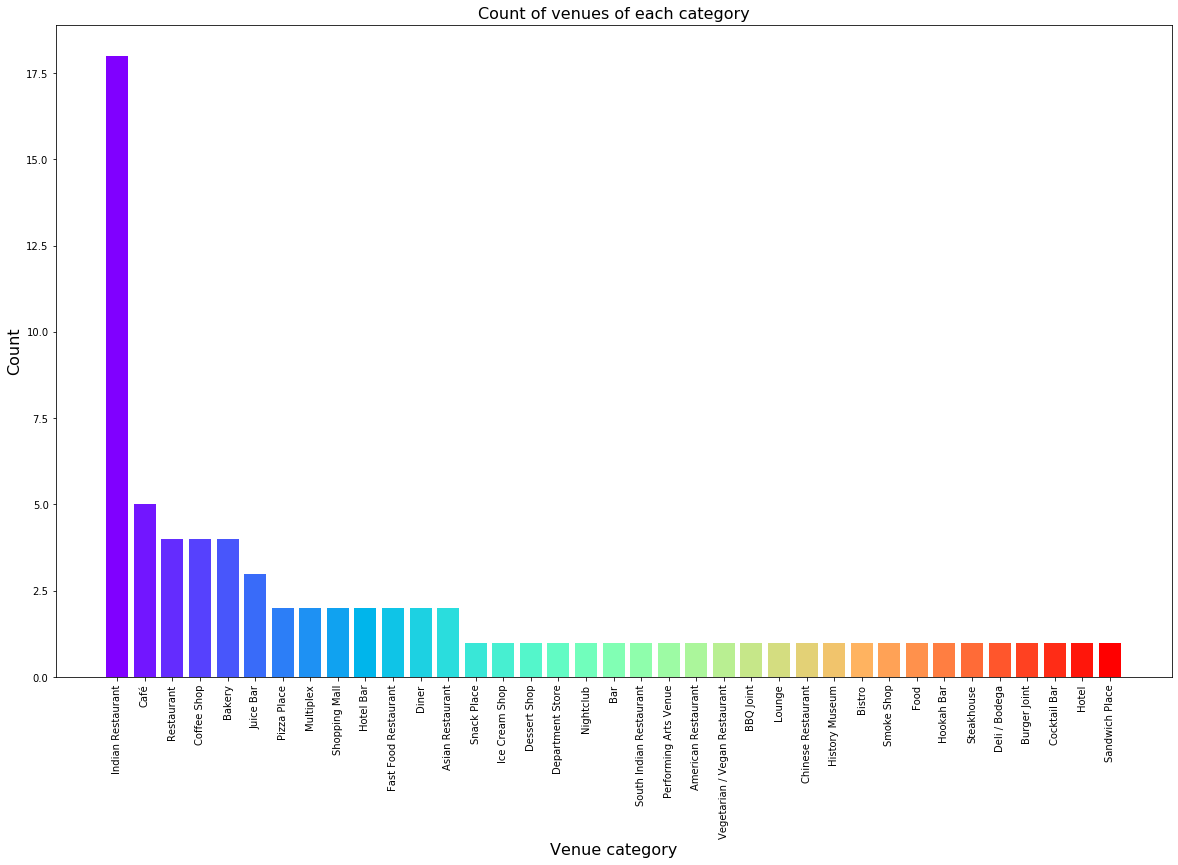

In [40]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are **Indian Restaurant** and **Cafe**.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

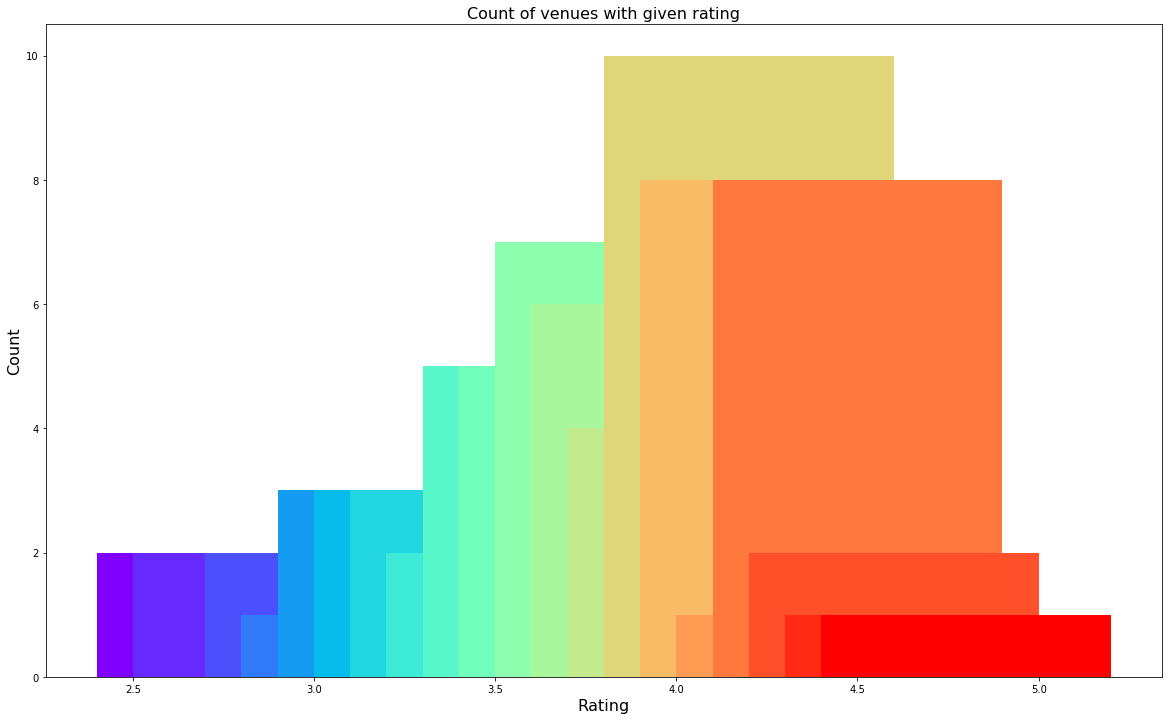

In [41]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)


From the plot above, it is clear that majority venues have their rating close to 6.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

- 1 to 2
- 2 to 3
- 3 to 4
- 4 to 5

In [42]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [43]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(hyderabad_map)  

hyderabad_map.save("map/Venues Ratings.html")
hyderabad_map

The map has the location of all the venues. It appears that many venues are located near about Panjagutta,Banjara Hills,Himayatnagar,Abids with rating above 3. If someone wants to explore new venues, they should definitely check out these venues.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

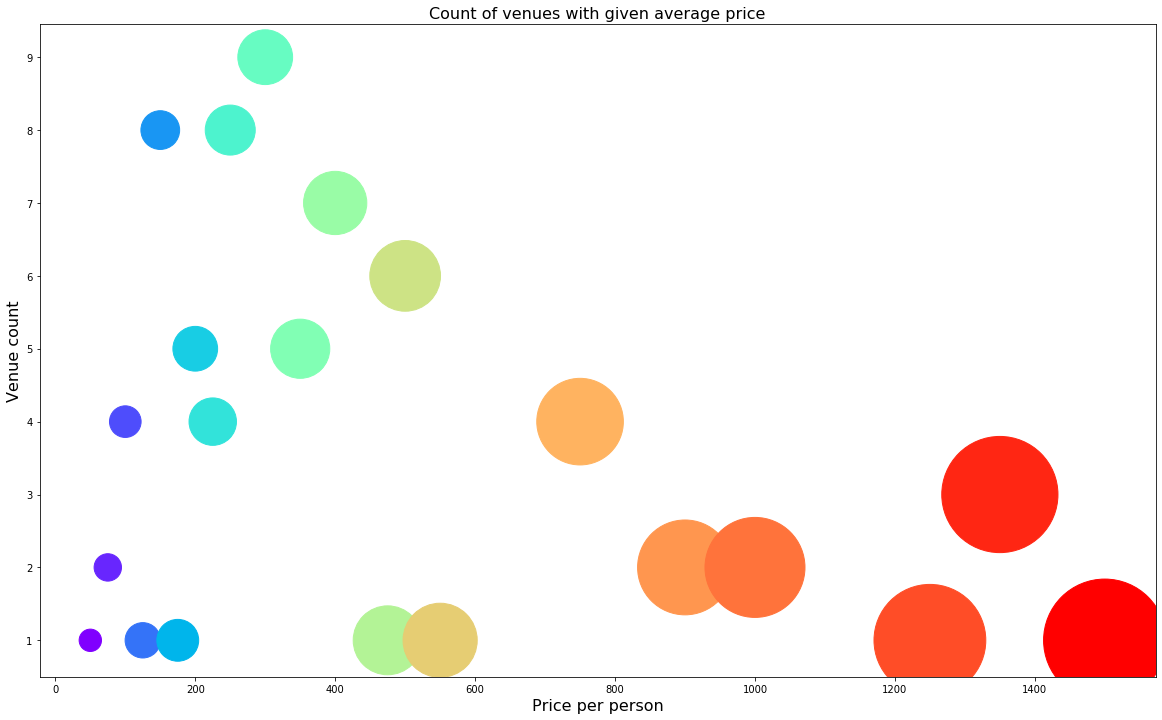

In [44]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 200 and Rs 500.

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [45]:

color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(hyderabad_map)  
    
hyderabad_map.save("map/Venues Prices.html")
hyderabad_map

1.The venues near Abids are primarily lower priced.\
2.The venues near Himayatnagar have steep prices.\
3.Banjara Hills and Punjagutta seems to have a mix of high priced and average priced venues.

### Clustering
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [46]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,South Indian Restaurant,Pragati Tiffin Center,17.3881,78.4813,1.0,4.2,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",75.0,Very good
1,0,Burger Joint,King And Cardinal Bakery,17.4006,78.4887,1.0,4.5,"3-5-908/1/2/3, Pooja Manor, Opposite TVS Showr...",175.0,Very good
2,0,Bakery,Karachi Bakery,17.3833,78.4750,1.0,4.3,"Mozamjahi Market, Nampally, Hyderabad",225.0,Very good
3,0,Ice Cream Shop,Shah Ice Cream,17.3844,78.4748,1.0,3.5,"Goshamahal Road, Chandra Vihar, Old Kattal Man...",150.0,Good
4,0,Diner,Hotel Shadab,17.3688,78.4755,2.0,4.4,"Plot 21, Opposite Madina Building, High Court ...",350.0,Very good


In [47]:
hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(hyderabad_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(hyderabad_map)

hyderabad_map.save("map/Venues Clusters.html")
hyderabad_map

In [48]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,South Indian Restaurant,Pragati Tiffin Center,17.3881,78.4813,1.0,4.2,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",75.0,Very good
1,0,Burger Joint,King And Cardinal Bakery,17.4006,78.4887,1.0,4.5,"3-5-908/1/2/3, Pooja Manor, Opposite TVS Showr...",175.0,Very good
2,0,Bakery,Karachi Bakery,17.3833,78.4750,1.0,4.3,"Mozamjahi Market, Nampally, Hyderabad",225.0,Very good
3,0,Ice Cream Shop,Shah Ice Cream,17.3844,78.4748,1.0,3.5,"Goshamahal Road, Chandra Vihar, Old Kattal Man...",150.0,Good
4,0,Diner,Hotel Shadab,17.3688,78.4755,2.0,4.4,"Plot 21, Opposite Madina Building, High Court ...",350.0,Very good
5,0,Indian Restaurant,KFC,17.4014,78.4857,1.0,4.1,"Shop 002, Prime Plaza, 3-6-196/197, Himayath N...",225.0,Very good
6,0,Indian Restaurant,Cafe Bahar,17.3996,78.4787,2.0,4.6,"3-5-815/A, Hyderguda, Hyderabad",300.0,Very good
7,0,Indian Restaurant,Hot N Tasty Chicken Shawarma,17.3727,78.4995,1.0,3.3,"Opposite Hotel Sohail, Malakpet, Hyderabad",125.0,Good
8,0,History Museum,Taj Restaurant,17.3593,78.4712,2.0,3.7,"20-4-214/19, Khilwat, Near Chowmahalla Palace,...",250.0,Good
9,0,Café,New Niloufer Cafe & Restaurant,17.3996,78.4628,2.0,3.9,"Red Hills, Near Niloufer Hospital, Lakdikapul,...",250.0,Good


In [49]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.70 and rating spread around 3.86


In [50]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Restaurant,MoMo Cafe - Courtyard By Marriott,17.4236,78.4877,4.0,4.0,"Opposite Hussain Sagar Lake, Tank Bund Road, N...",1350.0,Good
1,1,Hotel Bar,Aqua - The Park,17.4233,78.4627,4.0,4.3,"The Park Hotel, 22, Raj Bhavan Road, Somajigud...",1250.0,Very good
2,1,Nightclub,Kismet - The Park,17.4233,78.4627,4.0,4.2,"The Park Hotel, 22, 1st Floor, Raj Bhavan Road...",1500.0,Very good
3,1,American Restaurant,Hard Rock Cafe,17.4186,78.4486,4.0,4.5,"GVK One Mall, Ground Floor, Road 1, Banjara Hi...",1000.0,Very good
4,1,Indian Restaurant,Exotica,17.4103,78.4372,3.0,4.6,"5th Floor, 12th Square Building, Road 12, Oppo...",900.0,Very good
5,1,Indian Restaurant,Journey 1853,17.4151,78.4489,3.0,4.2,"5th Floor, City Center Mall, Road 1, Banjara H...",900.0,Very good
6,1,Indian Restaurant,AB's - Absolute Barbecues,17.4122,78.4495,3.0,4.8,"8-2-618/10-11, 2nd Floor, Krishe Amethyst, Roa...",750.0,Very good
7,1,Steakhouse,Chef Inam's Steak House,17.4088,78.4385,4.0,4.1,"Road 12, Opposite Kamaan, Fortune Enclave, Sri...",1000.0,Very good
8,1,Asian Restaurant,MoMo Cafe - Courtyard By Marriott,17.4236,78.4877,4.0,4.0,"Opposite Hussain Sagar Lake, Tank Bund Road, N...",1350.0,Good
9,1,Hotel,MoMo Cafe - Courtyard By Marriott,17.4236,78.4877,4.0,4.0,"Opposite Hussain Sagar Lake, Tank Bund Road, N...",1350.0,Good


In [51]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.54 and rating spread around 4.32


### Results and Discussion

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Hyderabad, India.

After collecting data from the **Foursquare** and **Zomato APIs**, we got a list of 155 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 76.

We identified that from the total set of venues, majority of them were **Indian Restaurants and Cafes** . A visitor who loves Indian Restaurants would surely benefit from coming to Hyderabad.

While the complete range of ratings range from 1 to 5, **the majority venues have ratings close to 4**. This means that most restaurants provide **good quality food** which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around **Panjagutta,Himayatnagar,Abids**. These clusters also have very high ratings (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 200 to Rs 500 for one person. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1500. On plotting the venues based on their price range on the map, we discovered that venues located near Abids are relatively priced lower than venues in Himayatnagar. A mix of medium price and high price exist in Banjara Hills and Panjagutta.

Finally, through clusters we identified that there are many venues which are **relatively lower priced but have an average rating of 3.86. On the other hand, there are few venues which are high priced and have average rating of 4.82**.

1.If you're looking for cheap places with relatively high rating, you should check **Abids**.\
2.If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit **Himayatnagar**.\
3.If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try **Punjagutta**.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## Conclusion

The purpose of this project was to explore the places that a person visiting Chandigarh could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are major areas a person can visit:Panjagutta,Banjara Hills,Himayatnagar,Abids. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.